# Load dataset

In [261]:
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("..")
from utils.diverse import *

from sklearn.utils import resample
    
def normalize(t):
    t = t - np.nanmin(t)
    t = t/np.nanmax(t)
    return t
    
with open("../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3030


In [262]:
iso = np.array([dataset["sws"][k]["iso"] for k in slow_wave_ids])
starts = np.array([dataset["sws"][k]["start"] for k in slow_wave_ids])
stops = np.array([dataset["sws"][k]["stop"] for k in slow_wave_ids])
width = np.array([dataset["sws"][k]["width"] for k in slow_wave_ids])
height = np.array([dataset["sws"][k]["height"] for k in slow_wave_ids])
gcamp = np.array([dataset["sws"][k]["gcamp_interpolated"] for k in slow_wave_ids])
gcamp_improved = np.array([dataset["sws"][k]["gcamp_improved_interpolated"] for k in slow_wave_ids])

hemo = np.array([dataset["sws"][k]["hemo_interpolated"] for k in slow_wave_ids])
left_too_high = np.array([dataset["sws"][k]["left_too_high"] for k in slow_wave_ids])
iso = np.array([dataset["sws"][k]["iso"] for k in slow_wave_ids])
corr = np.array([dataset["sws"][k]["correlation"] for k in slow_wave_ids])

#gcamp = np.array([dataset["sws"][k]["gcamp_mean_centered"] for k in slow_wave_ids])
#hemo = np.array([dataset["sws"][k]["hemo_mean_centered"] for k in slow_wave_ids])

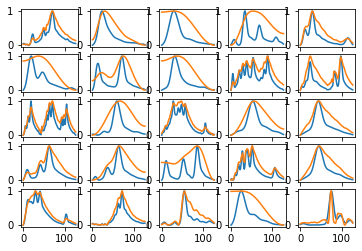

In [263]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,5)

it = 70
for i in range(5):
    for j in range(5):
        ax[i,j].plot(gcamp[height>10][it])
        ax[i,j].plot(gcamp_improved[height>10][it])

        it += 10

In [264]:
#gcamp = (gcamp[:,:128].T * height).T
#gcamp /= np.max(gcamp)

In [265]:
#Add heigth and width to each vector
x = np.vstack([gcamp.T, height.T, width.T, iso.T, corr.T, width.T, height.T]).T

In [266]:
x[:,128:128+2] = normalize(x[:,128:128+2])#Normalize heights & widths

In [267]:
x[left_too_high][:] = np.nan
x = x[~np.array([np.any(np.isnan(x1[:130])) for x1 in x])]#Remove invalid waves

In [268]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size = .25
batch_size = 100
x_train, x_test = train_test_split(x, test_size=test_size, random_state = random_state)

In [269]:
x_train.shape

(2272, 134)

In [270]:
x_test.shape

(758, 134)

In [271]:
iso_train = x_train[:,129+1]#Save isopropylene level seperately
iso_test = x_test[:,129+1]

corr_train = x_train[:,129+2]
corr_test = x_test[:,129+2]

width_train = x_train[:,129+3]#Not normalized
width_test = x_test[:,129+3]

height_train = x_train[:,129+4]
height_test = x_test[:,129+4]

x_train = x_train[:,:130]
x_test = x_test[:,:130]

In [272]:
height_classes = np.round(height_train*5, -1)
print(len(set(height_classes)))
height_classes[height_classes > 50] = 50

37


In [273]:
x_train_upsampled = resample(x_train, stratify=height_classes, n_samples = 4000, random_state = random_state)

In [274]:
len(iso_test)

758

In [275]:
np.max(height_train)

123.83477211532679

In [276]:
image_size = x_train.shape[1]
original_dim = 130

# Variational Autoenconder

In [277]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense, Conv2DTranspose, Reshape, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import tensorflow as tf
tf.compat.v1.disable_eager_execution()


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [278]:
def gradient(x):
    d = x[1:]-x[:-1]
    fd = tf.concat([x,x[-1]], 0).expand_dims(1)
    bd = tf.concat([x[0],x], 0).expand_dims(1)
    d = tf.concat([fd,bd], 1)
    return tf.reduce_mean(d,1)

In [304]:
def get_vae_loss(inputs, outputs, z_mean, z_log_var, reconstruction_loss = "mse", original_dim = 130):
    # VAE loss = mse_loss or binary_crossentropy + kl_loss
    #inputs = K.print_tensor(inputs, message="inputs")
    #outputs = K.print_tensor(outputs[0], message="outputs")

    if reconstruction_loss == "custom":
        reconstruction_loss = mse(inputs, outputs)+K.mean(gradient(inputs-outputs[0])**2)
        #reconstruction_loss = K.print_tensor(reconstruction_loss, message="")
    elif reconstruction_loss == "mse":
        reconstruction_loss = mse(inputs, outputs)

    reconstruction_loss *= original_dim
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    if reconstruction_loss == "custom":
        pass

    vae_loss = K.mean(5*reconstruction_loss + kl_loss)
    #vae_loss = K.print_tensor(vae_loss, message="")

    return vae_loss

In [305]:
## network parameters
input_shape = (130, )
original_dim = input_shape[0]
batch_size = 100
epochs = 100

In [306]:
def mlp_encoder(input_shape, latent_dim = 2, intermediate_dim = 512, layers = 3):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    print(inputs.shape)
    x = inputs
    for l in range(layers):
        x = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return inputs, [z_mean, z_log_var, z]

In [307]:
def mlp_decoder(original_dim, latent_dim = 2, intermediate_dim = 512, layers = 3):
    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for l in range(layers):
        x = Dense(intermediate_dim, activation='relu')(x)
    outputs = Dense(original_dim, activation='sigmoid')(x)
    return latent_inputs, outputs

In [308]:
def convolutional_decoder(latent_dim = 2, intermediate_dim = 512, layers = 3):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    d1 = Dense(64, activation='sigmoid', name="d1")(latent_inputs)
    d2 = Dense(1*32*30, activation='sigmoid', name = "d2")(d1)
    d3 = Reshape([1,32,30])(d2)
    deconv1 = Conv2DTranspose(filters=4,kernel_size=(1,5), activation='relu',strides=(1,1),padding='same')(d3)
    deconv2 = Conv2DTranspose(filters=4,kernel_size=(1,10), activation='relu',strides=(1,2),padding='same')(deconv1)
    deconv3 = Conv2DTranspose(filters=1,kernel_size=(1,20), activation='relu',strides=(1,2),padding='same')(deconv2)
    flatten = Flatten()(deconv3)
    d4 = Dense(2, activation="sigmoid", name="d4")(d2)
    output = Concatenate(axis=1)([flatten, d4])
    return latent_inputs, output

In [309]:
# VAE model
inputs, [z_mean, z_log_var, z] = mlp_encoder(input_shape)
latent_inputs, outputs = mlp_decoder(original_dim)
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Add loss and compile
vae.add_loss(get_vae_loss(inputs, outputs, z_mean, z_log_var))
vae.compile(optimizer='adam')

(None, 130)


In [310]:
# train the autoencoder
vae.fit(x_train_upsampled, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), verbose=1)

Train on 4000 samples, validate on 758 samples
Epoch 1/100
4000/4000 [==============================] - 4s 1ms/sample - loss: 46.4369 - val_loss: 29.7560
Epoch 2/100
4000/4000 [==============================] - 3s 864us/sample - loss: 24.7547 - val_loss: 21.4297
Epoch 3/100
4000/4000 [==============================] - 3s 767us/sample - loss: 20.6317 - val_loss: 19.5743
Epoch 4/100
4000/4000 [==============================] - 4s 940us/sample - loss: 18.6847 - val_loss: 17.4661
Epoch 5/100
4000/4000 [==============================] - 4s 915us/sample - loss: 16.7388 - val_loss: 15.1415
Epoch 6/100
4000/4000 [==============================] - 4s 909us/sample - loss: 14.7726 - val_loss: 14.0912
Epoch 7/100
4000/4000 [==============================] - 4s 935us/sample - loss: 13.6095 - val_loss: 13.0794
Epoch 8/100
4000/4000 [==============================] - 4s 972us/sample - loss: 13.1584 - val_loss: 13.1685
Epoch 9/100
4000/4000 [==============================] - 4s 979us/sample - loss: 13

4000/4000 [==============================] - 4s 1ms/sample - loss: 9.5133 - val_loss: 10.4914
Epoch 76/100
4000/4000 [==============================] - 4s 959us/sample - loss: 9.5562 - val_loss: 10.4001
Epoch 77/100
4000/4000 [==============================] - 4s 914us/sample - loss: 9.5013 - val_loss: 10.5023
Epoch 78/100
4000/4000 [==============================] - 4s 958us/sample - loss: 9.8823 - val_loss: 11.0908
Epoch 79/100
4000/4000 [==============================] - 4s 906us/sample - loss: 10.3942 - val_loss: 11.1557
Epoch 80/100
4000/4000 [==============================] - 4s 979us/sample - loss: 9.8804 - val_loss: 10.9288
Epoch 81/100
4000/4000 [==============================] - 4s 974us/sample - loss: 9.6147 - val_loss: 10.3465
Epoch 82/100
4000/4000 [==============================] - 4s 978us/sample - loss: 9.7769 - val_loss: 10.6858
Epoch 83/100
4000/4000 [==============================] - 4s 971us/sample - loss: 10.6795 - val_loss: 11.0673
Epoch 84/100
4000/4000 [========

# Visualization

In [311]:
from scipy.interpolate import interp1d

def stretch(vector, n_interp, norm = True):
    """ Stretches or squeezes vector to match desired output size """
    res = interp1d(np.arange(len(vector)), vector)(np.linspace(0, len(vector)-1, n_interp))
    if norm:
        res = normalize(res)
    return res

In [541]:
def fig2rgb_array(fig):
    """ Converts a matplotlib figure to an rgb array such that it may be displayed as an ImageDisplay
    Args:
        fig: Matplotlib figure
    Returns:
        arr: Image of the plot in the form of a numpy array
    """
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

def manifold(decoder, x_range = [-2,2], y_range = [-0.5, -2.5], n = 10, figsize=(8,8), dpi = 100, n_interp = 100, scale="sqrt"):
    x = np.linspace(x_range[0], x_range[1], n)
    y = np.linspace(y_range[0], y_range[1], n)
    m = np.array(np.meshgrid(y, x)).T
    
    predictions = np.ndarray((m.shape[0], m.shape[1]), dtype=np.ndarray)
    heights = np.ndarray((m.shape[0], m.shape[1]))
    widths = np.ndarray((m.shape[0], m.shape[1]))
    
    for y in range(predictions.shape[0]):
        for x in range(predictions.shape[1]):
            try:
                pred = decoder.predict(np.array([[m[x, -y]]], dtype=np.float32)).flatten()
            except:
                pred = decoder.predict(np.array([m[x, -y]], dtype=np.float32)).flatten()
            heights[y,x] = pred[-2]
            widths[y,x] = pred[-1]
            predictions[y,x] = pred[:-2]
            
            
    heights = heights / np.max(heights)
    if scale == "sqrt":
        heights = np.sqrt(heights)
    widths = widths / np.max(widths)
    if scale == "sqrt":
        widths = np.sqrt(widths)
    
    fig, ax = plt.subplots(n, n, figsize= figsize, dpi = dpi)
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
        
    for y in range(predictions.shape[0]):
        for x in range(predictions.shape[1]):
            print(widths[y,x])
            real_width = np.max([int(np.min(widths[y,x]) * n_interp), 2])#scale such that maximal width = n_interp
            pred = stretch(predictions[y,x], real_width)# ...
            pred *= heights[y,x]#Scale height
            indent = n_interp - real_width#Indent > 0
            vector = np.zeros(n_interp, dtype=np.float)
            vector.fill(np.nan)
            vector[indent:indent+real_width] = pred
            a = ax[y,x]#[n-1-y,x]
            a.set_xlim(0,n_interp)
            a.plot(pred)
            a.axis("off")
            a.set_ylim(0,1)
    return fig2rgb_array(fig)

In [542]:
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import string

def plot_latent_space_and_basic_features(res, iso, iso_train, corr_train, width_train, height_train, x_pred_train, y_pred_train):
    iso_levels = list(set(iso))
    iso_levels.sort()
    def format_axes(axes):
        current_iso_level = 0
        for i, ax in enumerate(axes):
            if i == 0:
                continue
            ax.tick_params(labelbottom=False, labelleft=False)
            ax.set_title("iso " + str(iso_levels[current_iso_level]) + "%")
            if i == 1:
                ax.set_ylabel("z [1]", fontsize = 8)
            ax.set_xlabel("z [0]", fontsize = 8)
            current_iso_level += 1


    fig = plt.figure(figsize=(9, 8), dpi=100)

    gs = GridSpec(4, 5, figure=fig, wspace=.2)
    gs.update(wspace=.25, hspace=.5)
    ax = []
    ax.append(fig.add_subplot(gs[:3, :3]))
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

    x_min = np.min(x_pred_train)
    y_min = np.min(y_pred_train)
    x_max = np.max(x_pred_train)
    y_max = np.max(y_pred_train)

    ax[0].tick_params(bottom=False, top=False, left = False, right=False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].imshow(res, aspect ="auto")
    ax[0].set_xlabel("z [0]", fontsize = 12)
    ax[0].set_ylabel("z [1]", fontsize = 12)

    ax.append(fig.add_subplot(gs[0:2, 3:5]))
    ax[-1].autoscale(enable=False)

    ax[-1].scatter(x_pred_train[np.abs(corr_train)>.3], y_pred_train[np.abs(corr_train)>.3], s = 5, c="lightblue")
    ax[-1].scatter(x_pred_train[np.abs(corr_train)<.3], y_pred_train[np.abs(corr_train)<.3], s = 5, c="red")
    ax[-1].set_xlim((x_min, x_max))
    ax[-1].set_ylim((y_min, y_max))
    ax[-1].set_ylabel("z [1]", fontsize = 8)
    ax[-1].set_xlabel("z [0]", fontsize = 8)
    ax[-1].tick_params(labelbottom=False, labelleft=False)


    ax.append(fig.add_subplot(gs[2, 3]))
    ax[-1].autoscale(enable=False)

    ax[-1].scatter(x_pred_train[width_train<25], y_pred_train[width_train<25], c = "lightblue", s =5)
    ax[-1].scatter(x_pred_train[width_train>25], y_pred_train[width_train>25], c = "red", s =5)
    ax[-1].set_xlim((x_min, x_max))
    ax[-1].set_ylim((y_min, y_max))
    ax[-1].set_xlim((x_min, x_max))
    ax[-1].set_ylim((y_min, y_max))
    ax[-1].set_ylabel("z [1]", fontsize = 8)
    ax[-1].set_xlabel("z [0]", fontsize = 8)
    ax[-1].tick_params(labelbottom=False, labelleft=False)

    ax.append(fig.add_subplot(gs[2, 4]))
    ax[-1].autoscale(enable=False)

    ax[-1].scatter(x_pred_train[height_train<5], y_pred_train[height_train<5], c = "lightblue", s =5)
    ax[-1].scatter(x_pred_train[height_train>5], y_pred_train[height_train>5], c = "red", s =5)
    ax[-1].scatter(x_pred_train[height_train>15], y_pred_train[height_train>15], c = "yellow", s =5)

    ax[-1].set_xlim((x_min, x_max))
    ax[-1].set_ylim((y_min, y_max))
    ax[-1].set_xlim((x_min, x_max))
    ax[-1].set_ylim((y_min, y_max))
    ax[-1].set_ylabel("z [1]", fontsize = 8)
    ax[-1].set_xlabel("z [0]", fontsize = 8)
    ax[-1].tick_params(labelbottom=False, labelleft=False)

    for i in range(5):
        ax.append(fig.add_subplot(gs[3:, i]))
        where = iso_train == iso_levels[i]
        xp = x_pred_train[where]
        yp = y_pred_train[where]
        xy = np.vstack([xp,yp])
        z = gaussian_kde(xy)(xy)
        ax[-1].autoscale(enable=False)
        ax[-1].scatter(x_pred_train, y_pred_train, s=10, edgecolor='', c="lightgray")
        ax[-1].scatter(xp, yp, c=z, s=10, edgecolor='', cmap="inferno")
        ax[-1].set_xlim((x_min,x_max))
        ax[-1].set_ylim((y_min,y_max))

    format_axes(ax[-6:])

    #axs[3].scatter(x_pred_train[height_train<5], y_pred_train[height_train<5], c = "yellow", s =5)
    #axs[3].scatter(x_pred_train[height_train>5], y_pred_train[height_train>5], c = "green", s =5)

    for i, a in enumerate(ax):
        if i == 0:
            a.text(-0.03, 1.03, string.ascii_uppercase[i], transform = a.transAxes, size= 15, weight = "bold")
        elif i == 1:
            a.text(-0.06, 1.03, string.ascii_uppercase[i], transform = a.transAxes, size= 15, weight = "bold")
        else:
            a.text(-0.1, 1.1, string.ascii_uppercase[i], transform = a.transAxes, size= 15, weight = "bold")

    #fig.colorbar(a, ax=ax[0], fraction=0.025)
    #fig.suptitle("")
    plt.show()

29.0


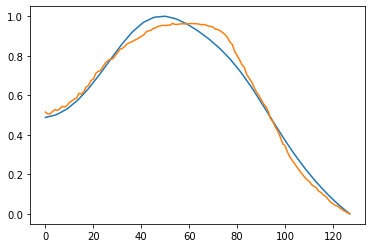

In [543]:
i = 7
res = vae.predict(x_train[i:i+1])
plt.plot(x_train[i][:-2])
print(width_train[i])

plt.plot(res[0][:-2])

In [544]:
x_test_latent = encoder.predict(x_test)


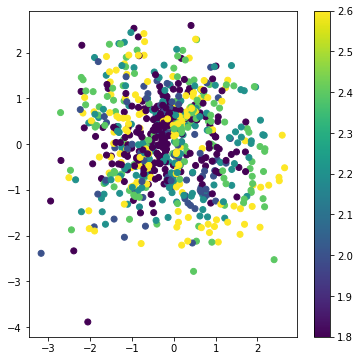

In [545]:
x, y = x_test_latent[2].T#v of latent dim
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c=iso_test)
plt.colorbar()
plt.show()

In [546]:
x_test_latent_train = encoder.predict(x_train)
x_pred_train, y_pred_train = x_test_latent_train[2].T

In [547]:
x_test_latent_test = encoder.predict(x_test)
x_pred_test, y_pred_test = x_test_latent_test[2].T

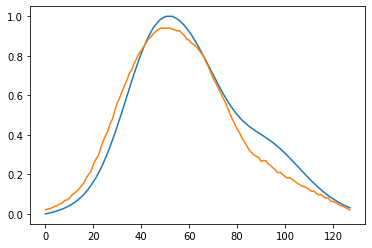

In [548]:
i = 300
res = vae.predict(x_train[i:i+1])
plt.plot(x_train[i][:-2])
plt.plot(res[0][:-2])

In [549]:
print("Width and height accuracy (pearsons r)")
pred = vae.predict(x_train)
print(np.corrcoef(pred[:,-2], x_train[:, -2])[0,1])
print(np.corrcoef(pred[:,-1], x_train[:, -1])[0,1])

Width and height accuracy (pearsons r)
0.5137051772924035
0.7434908717613904


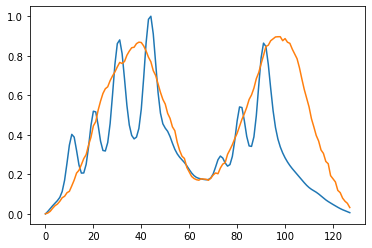

In [550]:
i = 200

res = vae.predict(x_test[i:i+1])
plt.plot(x_test[i][:-2])
plt.plot(res[0][:-2])

In [553]:
%%capture
x_range = [np.min(x_pred_train), np.max(x_pred_train)]
y_range = [np.min(y_pred_train),np.max(y_pred_train)]
x_range = [-2,2]
y_range = [-2,2]
res = manifold(decoder, x_range, y_range, n = 15, dpi = 300, scale="sqrt")

/home/ibmi/gerstenberger/anaconda3/envs/condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/home/ibmi/gerstenberger/anaconda3/envs/condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


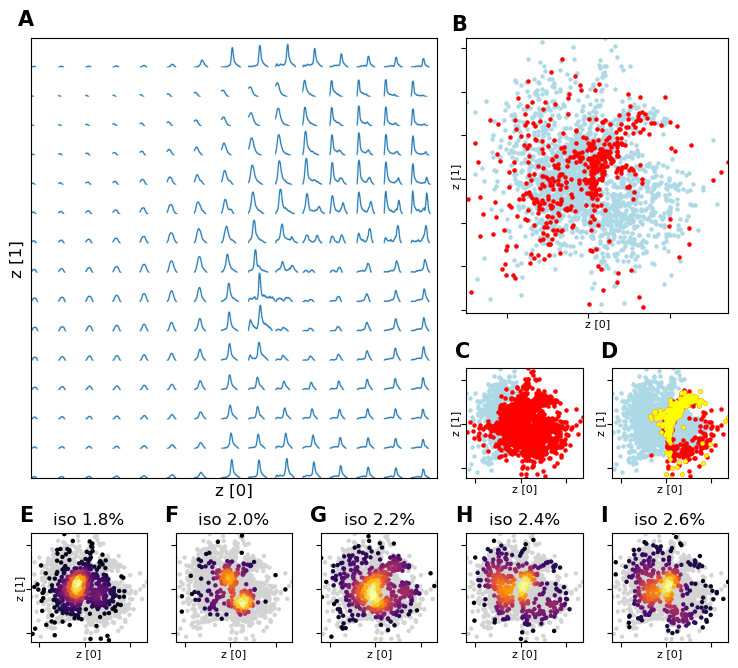

In [554]:
plot_latent_space_and_basic_features(res, iso, iso_train, corr_train, width_train, height_train, x_pred_train, y_pred_train)

In [299]:
%%capture
where = np.where(height_train > 10)
res1 = manifold(decoder, x_range = [np.min(x_pred_train[where]), np.max(x_pred_train[where])], 
                                   y_range = [np.min(y_pred_train[where]),np.max(y_pred_train[where])], n = 15, dpi = 300, increase_dim=False)

/home/ibmi/gerstenberger/anaconda3/envs/condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/home/ibmi/gerstenberger/anaconda3/envs/condaenv/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


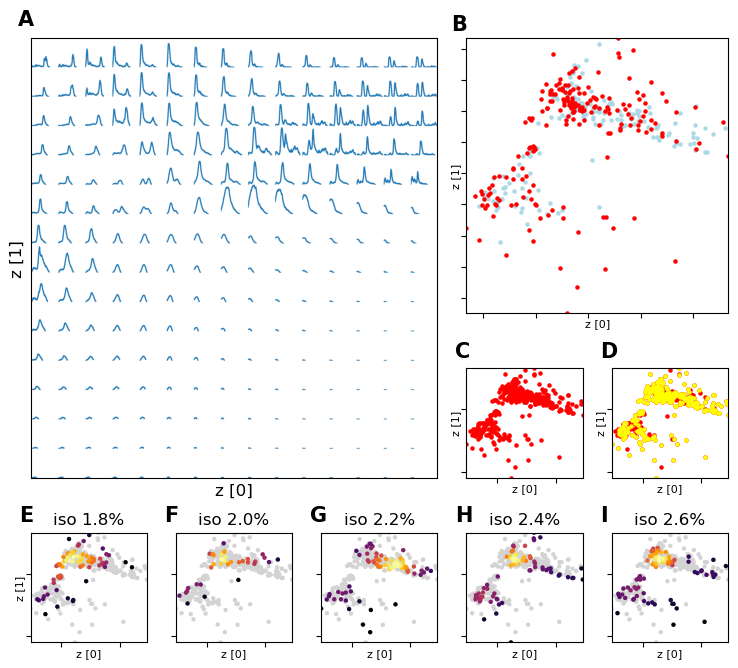

In [249]:
plot_latent_space_and_basic_features(res1, iso, iso_train[where], corr_train[where], width_train[where], height_train[where], x_pred_train[where], y_pred_train[where])

In [ ]:
plot_latent_space_and_basic_features(res, iso, iso_test, corr_test, width_test, height_test, x_pred_test, y_pred_test)

In [ ]:
i = 10
where = height_train > 5
plt.plot(x_train[where][i:i+1].T[:-2])
plt.plot(vae.predict(x_train[where][i:i+1]).T[:-2])

In [ ]:
i = 9
where = height_test > 10
plt.plot(x_test[where][i:i+1].T[:-2])
plt.plot(vae.predict(x_test[where][i:i+1]).T[:-2])

In [ ]:
import matplotlib.pyplot as plt


iso_levels = list(set(iso))
iso_levels.sort()
def format_axes(fig):
    current_iso_level = 0
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)
        if i < 5:
            ax.set_title("iso " + str(iso_levels[current_iso_level]) + "%")
        ax.set_xlabel("z [0]", fontsize = 8)
        ax.set_ylabel("z [1]", fontsize = 8)
        current_iso_level += 1


fig = plt.figure(constrained_layout=True, figsize=(8,3), dpi=200)

gs = GridSpec(2, 5, figure=fig, wspace=1)
ax = []
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

x_min = np.min(x_pred_train)
y_min = np.min(y_pred_train)
x_max = np.max(x_pred_train)
y_max = np.max(y_pred_train)

for i in range(5):
    ax.append(fig.add_subplot(gs[0, i]))
    where = iso_train == iso_levels[i]
    xp = x_pred_train[where]
    yp = y_pred_train[where]
    xy = np.vstack([xp,yp])
    z = gaussian_kde(xy)(xy)
    
    ax[-1].scatter(x_pred_train, y_pred_train, s=10, edgecolor='', c="lightgray")
    ax[-1].scatter(xp, yp, c=z, s=10, edgecolor='', cmap="inferno")
    ax[-1].set_xlim((x_min,x_max))
    ax[-1].set_ylim((y_min,y_max))
    
for i in range(5):
    ax.append(fig.add_subplot(gs[1, i]))
    where = iso_train == iso_levels[i]
    xp = x_pred_train[where]
    yp = y_pred_train[where]
    
    ax[-1].scatter(x_pred_train, y_pred_train, s=10, edgecolor='', c="darkblue")
    ax[-1].scatter(xp, yp, s=10, edgecolor='', c="orange")
    ax[-1].set_xlim((x_min,x_max))
    ax[-1].set_ylim((y_min,y_max))


#fig.suptitle("")
format_axes(fig)

plt.show()

In [ ]:
latent = np.array(([list([x[0]]) for x in encoder.predict(x_train[1:2])]))

In [ ]:
plt.plot(decoder.predict(latent)[0][0][:-2])

In [ ]:
%%capture
res = manifold(decoder, x_range = [np.min(x_pred_train), np.max(x_pred_train)], 
                                   y_range = [np.min(y_pred_train),np.max(y_pred_train)], n = 15, dpi = 300)

In [ ]:
fig, ax = plt.subplots(1, figsize= (12,12))
ax.imshow(res)
plt.axis("off")

In [ ]:
iso_train.shape